In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## 1. Загрузка данных, EDA

In [104]:
users_data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/4qY27tJ23G_B1g')
users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [105]:
users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [106]:
ab_orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prdO8FDQx7lzCg')
ab_orders 

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [107]:
ab_orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [108]:
ab_products = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/atwrlmB_wu-fHA')
ab_products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [109]:
ab_products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

Объединим первые два датасета users_data и abs_orders (пока без стоимости продукции), посмотрим на статусы заказов, удалим отмененные заказы.

In [110]:
orders = users_data.merge(ab_orders, how = 'inner', on = 'order_id')
orders

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [111]:
orders.isna().sum()

user_id          0
order_id         0
action           0
time             0
date             0
group            0
creation_time    0
product_ids      0
dtype: int64

In [112]:
orders.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [113]:
actions_per_order = orders.groupby(['user_id', 'order_id'], as_index = False) \
      .agg({'action': 'count'}) \
      .rename(columns = {'action': 'action_times'})
actions_per_order

,user_id,order_id,action_times
0,964,1255,1
1,964,1257,1
2,965,1256,1
3,965,3946,1
4,965,9097,1
...,...,...,...
4118,1980,57384,1
4119,1980,57498,1
4120,1980,58430,1
4121,1980,58460,1


In [114]:
orders = orders.merge(actions_per_order, how = 'inner', on = ['user_id', 'order_id'])
orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,action_times
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",1
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",1
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",2
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}",2
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"{84, 8, 24}",1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}",1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"{60, 41, 46}",1
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"{9, 62, 77}",1


Удалим заказы, которые имеют два действия action_times (заказ и отмена).

In [115]:
orders = orders.drop(orders.query('action_times == 2').index)
orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,action_times
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",1
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}",1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",1
5,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}",1
6,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}",1
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"{84, 8, 24}",1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}",1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"{60, 41, 46}",1
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"{9, 62, 77}",1


In [116]:
orders.action.unique()

array(['create_order'], dtype=object)

In [117]:
orders.action_times.unique()

array([1])

In [118]:
orders.order_id.nunique()

3909

Теперь в датасете orders остались все заказы, которые не были отменены. 
Значения в колонках time и creation_time должны полностью совпадать, так что одной из них можно пренебречь.
Но все-таки удостоверимся, что это действительно так.

In [119]:
if orders['time'].equals(orders['creation_time']):
    print("Значения в колонках одинаковы")
else:
    print("Значения в колонках различаются")

Значения в колонках одинаковы


Удалим колонки time; action_times (лежит одно значение); action (лежит одно значение) за отсутствием необходимости в них.

In [120]:
orders = orders.drop(['time', 'action_times', 'action'], axis = 1)
orders

,user_id,order_id,date,group,creation_time,product_ids
0,964,1255,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
5,967,1259,2022-08-26,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
6,968,1261,2022-08-26,0,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"
...,...,...,...,...,...,...
4332,990,59422,2022-09-08,1,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4333,1418,59439,2022-09-08,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4334,1605,59464,2022-09-08,0,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4335,1461,59487,2022-09-08,0,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [121]:
orders.dtypes

user_id           int64
order_id          int64
date             object
group             int64
creation_time    object
product_ids      object
dtype: object

Колонки date и creation_time пока оставим строковыми, но уберем из date дату (оставим только год и месяц).

In [122]:
orders['date'] = orders['date'].apply(lambda x: '-'.join(x.split('-')[:2]))
orders

,user_id,order_id,date,group,creation_time,product_ids
0,964,1255,2022-08,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,2022-08,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,2022-08,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
5,967,1259,2022-08,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
6,968,1261,2022-08,0,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"
...,...,...,...,...,...,...
4332,990,59422,2022-09,1,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4333,1418,59439,2022-09,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4334,1605,59464,2022-09,0,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4335,1461,59487,2022-09,0,2022-09-08 23:29:06.000000,"{9, 62, 77}"


Посмотрим, за какой период заказы.

In [123]:
orders.date.unique()

array(['2022-08', '2022-09'], dtype=object)

Заказы (без отмены) - за август или сентябрь 2022 года.

Раз в данных только 2022 год, то можно оставить только месяц в колонке, а год вынести в название колонки.

Также переименуем данные в колонке "group" на *control* и *test*.

In [124]:
orders['date'] = orders['date'].apply(lambda x: 'August' if x == '2022-08' else 'September')
orders= orders.rename(columns = {'date': 'month_2022'})

In [125]:
orders['group'] = orders['group'].apply(lambda x: 'test' if x == 1 else 'control')
orders

,user_id,order_id,month_2022,group,creation_time,product_ids
0,964,1255,August,control,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,August,test,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,August,control,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
5,967,1259,August,test,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
6,968,1261,August,control,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"
...,...,...,...,...,...,...
4332,990,59422,September,test,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4333,1418,59439,September,test,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4334,1605,59464,September,control,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,"{9, 62, 77}"


Теперь нужно распарсить колонку *products_ids*, переименовать ее в *product_id*, и далее смерджить датасеты "orders" и "ab_products" по *product_id*.

In [126]:
orders['product_ids'] = orders['product_ids'].apply(lambda x: x.replace('{','').replace('}','').split(','))
orders

,user_id,order_id,month_2022,group,creation_time,product_ids
0,964,1255,August,control,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,August,test,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,August,control,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
5,967,1259,August,test,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"
6,968,1261,August,control,2022-08-26 00:05:35.000000,"[30, 35, 69, 6]"
...,...,...,...,...,...,...
4332,990,59422,September,test,2022-09-08 23:13:03.000000,"[84, 8, 24]"
4333,1418,59439,September,test,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]"
4334,1605,59464,September,control,2022-09-08 23:22:27.000000,"[60, 41, 46]"
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,"[9, 62, 77]"


In [127]:
orders = orders.explode('product_ids')
orders

,user_id,order_id,month_2022,group,creation_time,product_ids
0,964,1255,August,control,2022-08-26 00:00:19.000000,75
0,964,1255,August,control,2022-08-26 00:00:19.000000,22
0,964,1255,August,control,2022-08-26 00:00:19.000000,53
0,964,1255,August,control,2022-08-26 00:00:19.000000,84
1,965,1256,August,test,2022-08-26 00:02:21.000000,56
...,...,...,...,...,...,...
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,9
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,62
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,77
4336,1376,59533,September,control,2022-09-08 23:41:24.000000,17


In [128]:
orders = orders.rename(columns = {'product_ids': 'product_id'})
orders

,user_id,order_id,month_2022,group,creation_time,product_id
0,964,1255,August,control,2022-08-26 00:00:19.000000,75
0,964,1255,August,control,2022-08-26 00:00:19.000000,22
0,964,1255,August,control,2022-08-26 00:00:19.000000,53
0,964,1255,August,control,2022-08-26 00:00:19.000000,84
1,965,1256,August,test,2022-08-26 00:02:21.000000,56
...,...,...,...,...,...,...
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,9
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,62
4335,1461,59487,September,control,2022-09-08 23:29:06.000000,77
4336,1376,59533,September,control,2022-09-08 23:41:24.000000,17


In [129]:
orders.isna().sum()

user_id          0
order_id         0
month_2022       0
group            0
creation_time    0
product_id       0
dtype: int64

In [130]:
orders.dtypes

user_id           int64
order_id          int64
month_2022       object
group            object
creation_time    object
product_id       object
dtype: object

In [131]:
orders['product_id'] = orders['product_id'].astype('int')
orders.dtypes

user_id           int64
order_id          int64
month_2022       object
group            object
creation_time    object
product_id        int64
dtype: object

In [132]:
orders = orders.merge(ab_products, how = 'inner', on = 'product_id')
orders

,user_id,order_id,month_2022,group,creation_time,product_id,name,price
0,964,1255,August,control,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,August,control,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,August,test,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,August,test,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,August,test,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0
...,...,...,...,...,...,...,...,...
13078,1883,33910,September,test,2022-09-03 23:46:53.000000,11,масло льняное,200.0
13079,1440,34742,September,control,2022-09-04 03:41:52.000000,11,масло льняное,200.0
13080,1813,41998,September,test,2022-09-05 10:26:46.000000,11,масло льняное,200.0
13081,1175,53851,September,control,2022-09-07 23:53:54.000000,11,масло льняное,200.0


In [133]:
orders.dtypes

user_id            int64
order_id           int64
month_2022        object
group             object
creation_time     object
product_id         int64
name              object
price            float64
dtype: object

In [134]:
orders.isna().sum()

user_id          0
order_id         0
month_2022       0
group            0
creation_time    0
product_id       0
name             0
price            0
dtype: int64

Датасет orders, с которым можно работать, сформирован.

## 2. графики, гипотезы и тесты

Попробуем посмотреть, как взаимосвязаны в двух группах: 
 - заказы и месяц
 - заказы и товары в заказе
 - заказы и сумма чека

Для этого рассмотрим четыре метрики для сравнения контрольной и тестовой групп:

- среднее количество заказов на одного покупателя в месяц (*Average Number Orders Per User Within Month* - **ANOUM**)
- среднее количество товаров в заказе (*Average Number Products Per Order* - **ANPO**)
- средний чек на одного покупателя (*Average Receipt Per User* - **ARPU**)
- средняя сумма всех заказов (*Average Total Bill* - **ATB**)

### Рассмотрим ANOUM ###

In [135]:
ANOUM = orders.groupby(['user_id', 'month_2022', 'group'], as_index = False) \
     .agg({'order_id': 'nunique'}) \
     .rename(columns = {'order_id': 'number_orders_per_user'})
ANOUM

,user_id,month_2022,group,number_orders_per_user
0,964,August,control,2
1,965,August,test,6
2,965,September,test,3
3,967,August,test,5
4,968,August,control,3
...,...,...,...,...
1628,1978,September,test,3
1629,1979,August,test,1
1630,1979,September,test,4
1631,1980,August,test,2


Поскольку у нас два месяца (*August* и *September*), а также две группы (*test* и *control*), то для последующих сравнений между группами, создадим третью колонку combination.

In [136]:
ANOUM = ANOUM.assign(combination = ANOUM['group'] + ' \ ' + ANOUM['month_2022'])
ANOUM

,user_id,month_2022,group,number_orders_per_user,combination
0,964,August,control,2,control \ August
1,965,August,test,6,test \ August
2,965,September,test,3,test \ September
3,967,August,test,5,test \ August
4,968,August,control,3,control \ August
...,...,...,...,...,...
1628,1978,September,test,3,test \ September
1629,1979,August,test,1,test \ August
1630,1979,September,test,4,test \ September
1631,1980,August,test,2,test \ August


Теперь посмотрим на ANOUM.

In [137]:
ANOUM.groupby(['month_2022', 'group'])['number_orders_per_user'].describe()

count      mean       std  min  25%  50%  75%   max
month_2022 group                                                       
August     control  505.0  2.081188  1.289204  1.0  1.0  2.0  3.0   8.0
           test     497.0  3.072435  1.668851  1.0  2.0  3.0  4.0  11.0
September  control  269.0  1.769517  1.215126  1.0  1.0  1.0  2.0   9.0
           test     362.0  2.361878  1.501240  1.0  1.0  2.0  3.0   8.0

Видно, что в тестовой группе ANOUM выше, чем в контрольной (mean). 
Попробуем подтвердить это статистически.

Сначала уточним, является ли распределение в группах нормальным, а также равны ли дисперсии.

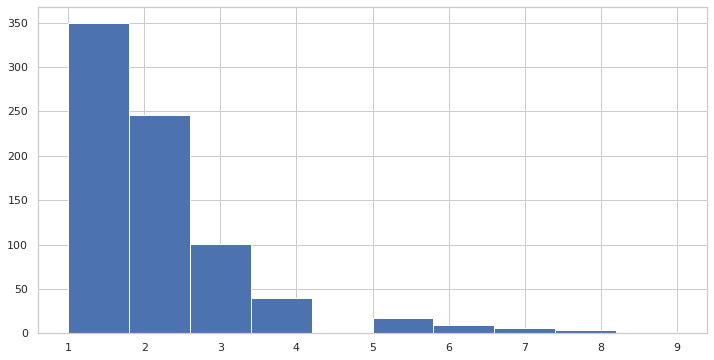

In [138]:
ANOUM.query('group == "control"')['number_orders_per_user'].hist()

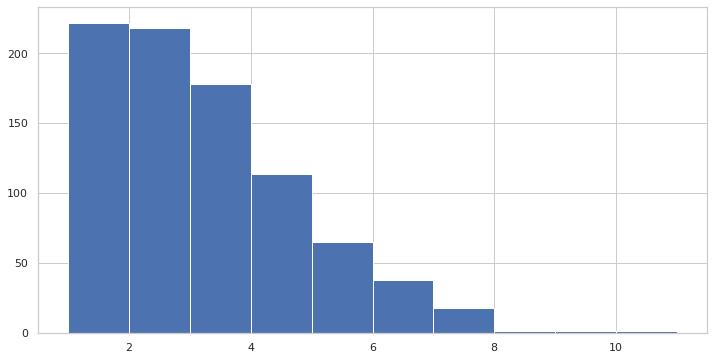

In [139]:
ANOUM.query('group == "test"')['number_orders_per_user'].hist()

In [140]:
A = ANOUM.query('group == "control"').number_orders_per_user
B = ANOUM.query('group == "test"').number_orders_per_user

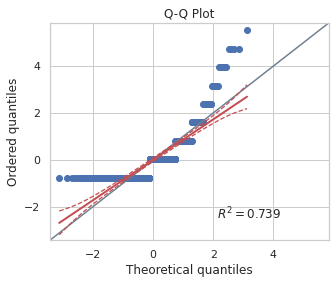

In [141]:
pg.qqplot(A)

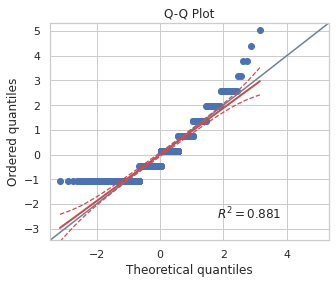

In [142]:
pg.qqplot(B)

In [143]:
pg.normality(data=ANOUM, dv="number_orders_per_user", group= "group", method="shapiro")

,W,pval,normal
control,0.739169,4.029771e-33,False
test,0.880790,3.883236e-25,False


In [144]:
pg.normality(data=ANOUM, dv="number_orders_per_user", group="group", method="normaltest")

,W,pval,normal
control,328.782306,4.034868e-72,False
test,133.988773,8.029854e-30,False


In [145]:
pg.homoscedasticity(data=ANOUM, dv="number_orders_per_user", group="group")

,W,pval,equal_var
levene,55.413916,1.573022e-13,False


Согласно полученным результатам распределения не являются нормальными, дисперсии не равны.

Попробуем взять логарифм.

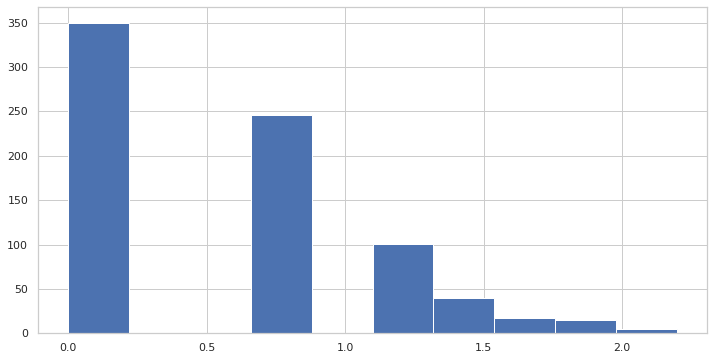

In [146]:
old_group = ANOUM.query('group == "control"')
np.log(old_group['number_orders_per_user']).hist()

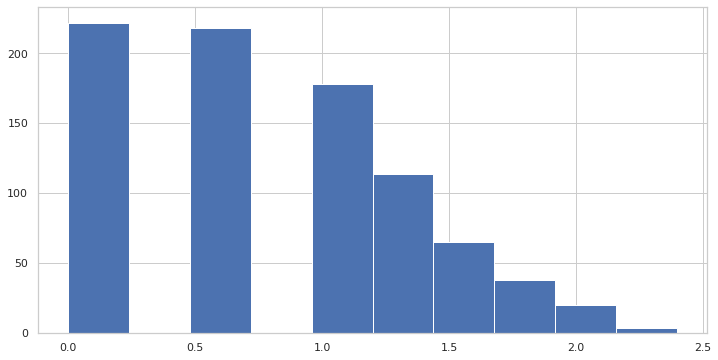

In [147]:
new_group = ANOUM.query('group == "test"')
np.log(new_group['number_orders_per_user']).hist()

Логарифмирование значений не помогло.

Поскольку нужно проверить влияние двух факторов (месяц и группа) на среднее количество заказов на пользователя то, т.к. выборка у нас достаточно большая, можно провести многофакторный ANOVA с поправкой Уэлча на неравенство дисперсии (typ = 3). 

Затем использовать критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия. 
А также посмотреть на средние во всех группах, построив график pointplot.

In [148]:
model_main = smf.ols("number_orders_per_user ~ month_2022 + group + month_2022:group", data=ANOUM).fit()
anova_lm(model_main, typ = 3)

,sum_sq,df,F,PR(>F)
Intercept,2187.328713,1.0,1039.316342,8.703032e-177
month_2022,17.048908,1.0,8.100844,4.479871e-03
group,246.117995,1.0,116.943765,2.266677e-26
month_2022:group,15.193508,1.0,7.219245,7.285950e-03
Residual,3428.367601,1629.0,NaN,NaN


In [149]:
pairwise_tukeyhsd(ANOM.number_orders_per_user, ANOUM.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ August,control \ September,-0.3117,0.0232,-0.5933,-0.0301,True
control \ August,test \ August,0.9912,0.001,0.7555,1.227,True
control \ August,test \ September,0.2807,0.0258,0.0238,0.5376,True
control \ September,test \ August,1.3029,0.001,1.0205,1.5853,True
control \ September,test \ September,0.5924,0.001,0.292,0.8927,True
test \ August,test \ September,-0.7106,0.001,-0.9683,-0.4528,True


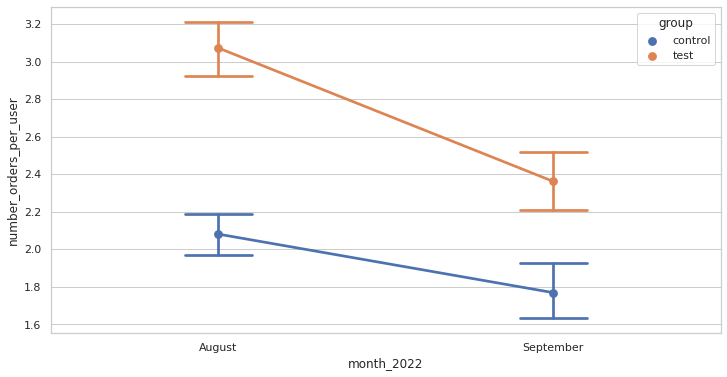

In [150]:
sns.pointplot(x="month_2022", y="number_orders_per_user", hue="group", data=ANOUM, capsize=0.2)

**Вывод**: Фактор "group" оказался значимым, фактор "month_2022" – значимым, их взаимодействие – значимо. 
Для обоих сегментов в тестовой группе показатели статистически значимо *увеличились* по сравнению с контрольной группой.
На графике *pointplot* для всех групп метрика ANOUM *выросла*.

### Рассмотрим ANPO ###

In [49]:
ANPO = orders.groupby(['order_id', 'group'], as_index = False) \
     .agg({'product_id': 'count'}) \
     .rename(columns = {'product_id': 'number_products_per_user'})
ANPO

,order_id,group,number_products_per_user
0,1255,control,4
1,1256,test,3
2,1257,control,4
3,1259,test,4
4,1261,control,4
...,...,...,...
3904,59422,test,3
3905,59439,test,5
3906,59464,control,3
3907,59487,control,3


Вычислим ANPO.

In [50]:
ANPO.groupby('group')['number_products_per_user'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,1527.0,3.341847,1.277273,1.0,2.0,3.0,4.0,8.0
test,2382.0,3.350126,1.291590,1.0,2.0,3.0,4.0,8.0


Видно, что ANPO незначительно выше в тестовой группе. Проверим, есть ли статистическая значимость в такой незначительной разнице. 

Прежде чем проводить статистический тест, посмотрим на распределение и дисперсию.

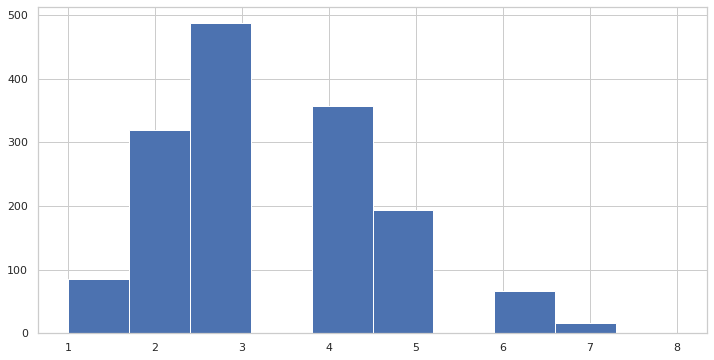

In [51]:
ANPO.query('group == "control"')['number_products_per_user'].hist()

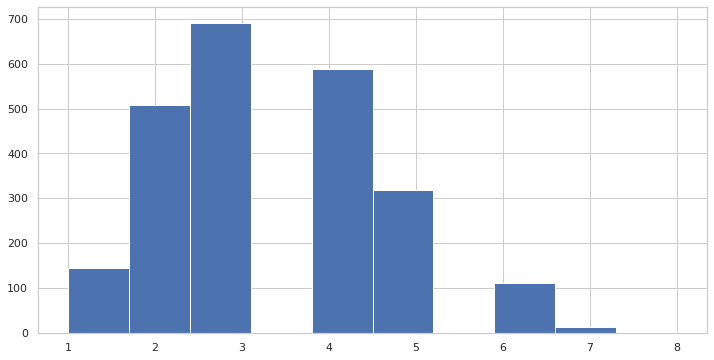

In [52]:
ANPO.query('group == "test"')['number_products_per_user'].hist()

In [53]:
A = ANPO.query('group == "control"').number_products_per_user
B = ANPO.query('group == "test"').number_products_per_user

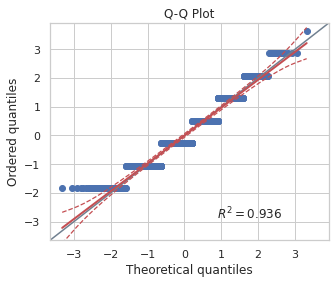

In [54]:
pg.qqplot(A)

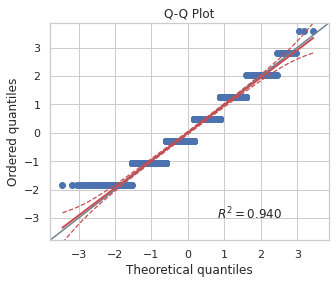

In [55]:
pg.qqplot(B)

In [56]:
pg.normality(data=ANPO, dv="number_products_per_user", group= "group", method="shapiro")

,W,pval,normal
control,0.935972,4.123596e-25,False
test,0.939656,4.217123e-30,False


In [57]:
pg.normality(data=ANPO, dv="number_products_per_user", group= "group", method="normaltest")

,W,pval,normal
control,36.287512,1.319067e-08,False
test,42.201912,6.854430e-10,False


In [58]:
pg.homoscedasticity(data=ANPO, dv="number_products_per_user", group="group")

,W,pval,equal_var
levene,1.787948,0.181254,True


Графики и проведенные тесты показали, что распределения в обоих группах не являются нормальными. Дисперсии же гомогенны.

Попробуем и здесь применить логарифмирование.

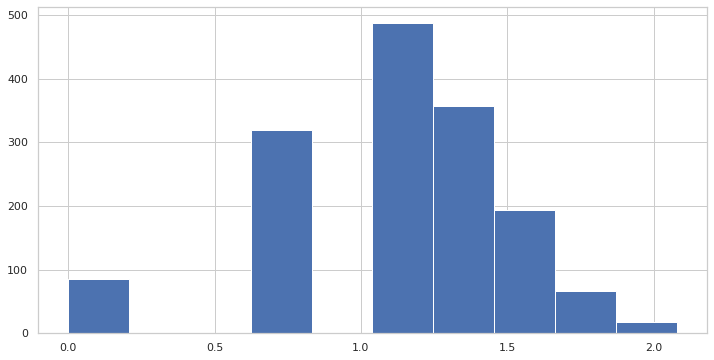

In [59]:
old_group = ANPO.query('group == "control"')
np.log(old_group['number_products_per_user']).hist()

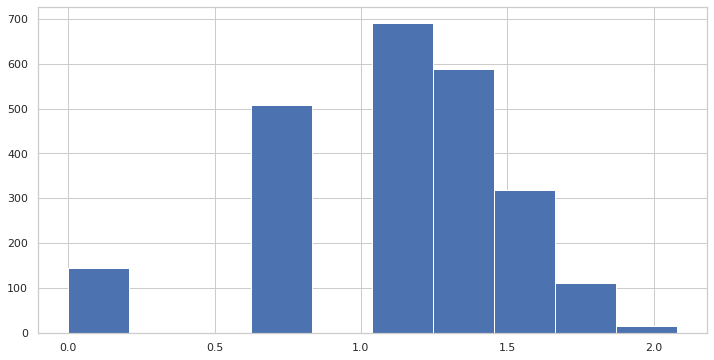

In [60]:
new_group = ANPO.query('group == "test"')
np.log(new_group['number_products_per_user']).hist()

Логарифмирование ситуацию не улучшило.

Так как у нас достаточно большая выборка, соблюдена гомогенность дисперсий, то в данной ситуации можно применить t-тест.

In [61]:
statistic, pvalue = ss.ttest_ind(ANPO.query('group == "test"')['number_products_per_user'], ANPO.query('group == "control"')['number_products_per_user'], equal_var=True)

print(f"t-статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

t-статистика: 0.19638057741712578
p-значение: 0.84432251088501
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


**Вывод**: Несмотря на то, что незначительная разница в среднем количестве товаров в заказе в тесте и контроле - есть, она не является статистически значимой. Метрика ANPO двух групп значимо не различается.

### Рассмотрим ARPU ###

In [62]:
orders

,user_id,order_id,month_2022,group,creation_time,product_id,name,price
0,964,1255,August,control,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,987,1287,August,control,2022-08-26 00:31:36.000000,75,сок ананасовый,120.0
2,1073,1403,August,test,2022-08-26 03:01:40.000000,75,сок ананасовый,120.0
3,1089,1424,August,test,2022-08-26 04:01:22.000000,75,сок ананасовый,120.0
4,1139,1495,August,test,2022-08-26 06:04:05.000000,75,сок ананасовый,120.0
...,...,...,...,...,...,...,...,...
13078,1883,33910,September,test,2022-09-03 23:46:53.000000,11,масло льняное,200.0
13079,1440,34742,September,control,2022-09-04 03:41:52.000000,11,масло льняное,200.0
13080,1813,41998,September,test,2022-09-05 10:26:46.000000,11,масло льняное,200.0
13081,1175,53851,September,control,2022-09-07 23:53:54.000000,11,масло льняное,200.0


Сначала рассчитаем сумму заказов каждого пользоателя.

In [63]:
price = orders.groupby(['user_id', 'group'], as_index = False) \
     .agg({'price': 'sum'}) \
     .rename(columns = {'price': 'orders_price'})
price

,user_id,group,orders_price
0,964,control,718.9
1,965,test,4155.5
2,967,test,1137.4
3,968,control,1590.7
4,969,control,681.9
...,...,...,...
1008,1976,test,2001.9
1009,1977,test,781.2
1010,1978,test,2276.3
1011,1979,test,1907.1


Далее вычислим количество заказов, созданных каждым пользователем.

In [64]:
number_orders = orders.groupby(['user_id', 'group'], as_index = False) \
     .agg({'order_id': 'nunique'}) \
     .rename(columns = {'order_id': 'number_orders'})
number_orders

,user_id,group,number_orders
0,964,control,2
1,965,test,9
2,967,test,5
3,968,control,3
4,969,control,2
...,...,...,...
1008,1976,test,5
1009,1977,test,4
1010,1978,test,6
1011,1979,test,5


Смерджим датасеты и вычислим ARPU каждого пользователя.

In [65]:
ARPU = price.merge(number_orders, how = 'inner', on = ['user_id', 'group'])
ARPU

,user_id,group,orders_price,number_orders
0,964,control,718.9,2
1,965,test,4155.5,9
2,967,test,1137.4,5
3,968,control,1590.7,3
4,969,control,681.9,2
...,...,...,...,...
1008,1976,test,2001.9,5
1009,1977,test,781.2,4
1010,1978,test,2276.3,6
1011,1979,test,1907.1,5


In [66]:
ARPU = ARPU.assign(ARPU = ARPU.orders_price / ARPU.number_orders)
ARPU

,user_id,group,orders_price,number_orders,ARPU
0,964,control,718.9,2,359.450000
1,965,test,4155.5,9,461.722222
2,967,test,1137.4,5,227.480000
3,968,control,1590.7,3,530.233333
4,969,control,681.9,2,340.950000
...,...,...,...,...,...
1008,1976,test,2001.9,5,400.380000
1009,1977,test,781.2,4,195.300000
1010,1978,test,2276.3,6,379.383333
1011,1979,test,1907.1,5,381.420000


Посмотрим на ARPU в каждой группе.

In [240]:
ARPU.groupby('group')['ARPU'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,512.0,386.039053,172.036518,25.0,268.881818,362.666667,475.883333,1240.8
test,501.0,371.203622,131.242699,83.5,286.066667,355.925000,434.437500,937.4


Видно, что ARPU в контрольной группе выше, чем в тестовой (mean). Уточним значимое ли это различие.

Проверим нормальность распределения и дисперсию. 

Если что-то не так, попробуем и здесь сначала взять логарифм.

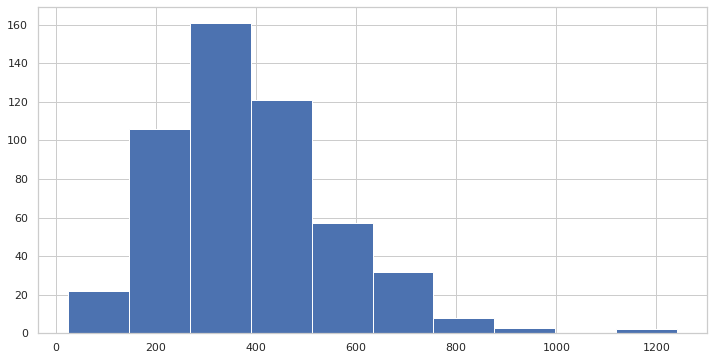

In [67]:
ARPU.query('group == "control"')['ARPU'].hist()

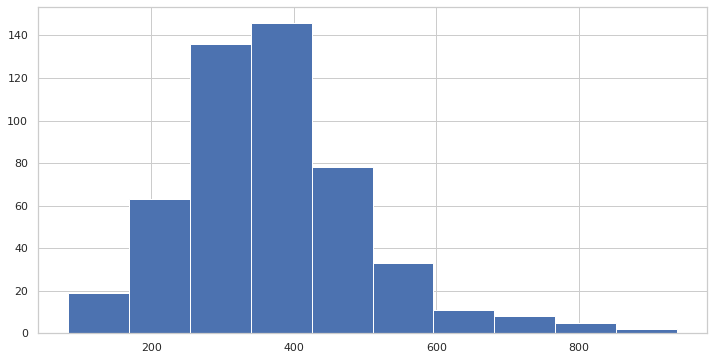

In [68]:
ARPU.query('group == "test"')['ARPU'].hist()

In [69]:
A = ARPU.query('group == "control"').ARPU
B = ARPU.query('group == "test"').ARPU

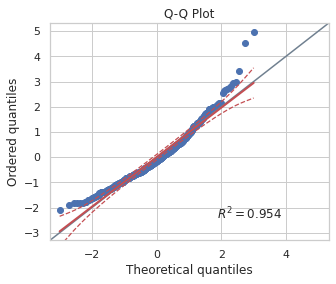

In [70]:
pg.qqplot(A)

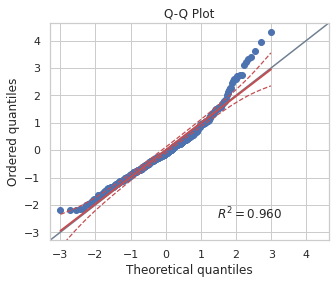

In [71]:
pg.qqplot(B)

In [72]:
pg.normality(data=ARPU, dv="ARPU", group= "group", method="shapiro")

,W,pval,normal
control,0.955415,2.553676e-11,False
test,0.960109,2.093885e-10,False


In [73]:
pg.normality(data=ARPU, dv="ARPU", group= "group", method="normaltest")

,W,pval,normal
control,82.503208,1.215223e-18,False
test,71.621174,2.803236e-16,False


In [74]:
pg.homoscedasticity(data=ARPU, dv="ARPU", group="group")

,W,pval,equal_var
levene,26.849002,2.655092e-07,False


Графики и проведенные тесты показали, что распределения в обеих группах не являются нормальными, дисперсии разные.

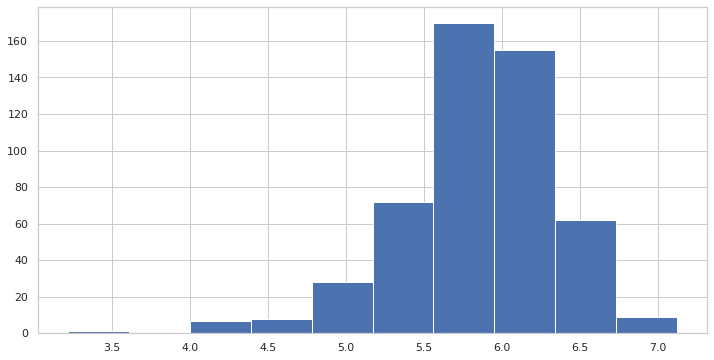

In [75]:
old_group = ARPU.query('group == "control"')
np.log(old_group['ARPU']).hist()

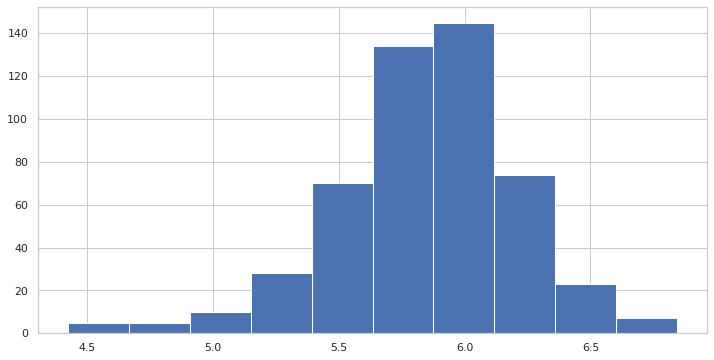

In [76]:
new_group = ARPU.query('group == "test"')
np.log(new_group['ARPU']).hist()

Логарифмирование также не помогло

Так как у нас достаточно большая выборка, но не соблюдена гомогенность дисперсий, то в данной ситуации можно применить t-тест Уэлча.

In [81]:
statistic, pvalue = ss.ttest_ind(ARPU.query('group == "test"')['ARPU'], ARPU.query('group == "control"')['ARPU'], equal_var=False)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: -1.5451367735756094
p-значение: 0.12264464021798412
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


**Вывод:** Несмотря на то, что ARPU в тесте и контроле различается (в контроле эта метрика имеет даже немного более высокий показатель), но статистически значимой разницы нет. Метрика ARPU двух групп значимо не различается.

### Рассмотрим ATB ###

In [86]:
total_bill = orders.groupby(['user_id', 'group'], as_index = False) \
     .agg({'price': 'sum'}) \
     .rename(columns = {'price': 'orders_price'})
total_bill

,user_id,group,orders_price
0,964,control,718.9
1,965,test,4155.5
2,967,test,1137.4
3,968,control,1590.7
4,969,control,681.9
...,...,...,...
1008,1976,test,2001.9
1009,1977,test,781.2
1010,1978,test,2276.3
1011,1979,test,1907.1


In [88]:
total_bill.groupby('group')['orders_price'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,512.0,1139.562305,809.808924,25.0,571.7,955.7,1498.6,5589.8
test,501.0,1753.749301,928.760937,83.5,1065.8,1630.1,2376.0,4576.2


Предварительная оценка показывает, что ATB в тестовой группе значительно выше, чем в контрольной (mean). Проверим значимая ли это разница.

Перед проведением статистического теста снова уточним информацию о распределении и дисперсии в двух группах.

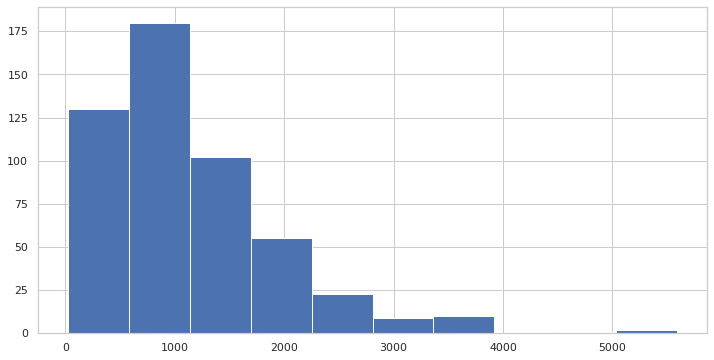

In [91]:
total_bill.query('group == "control"')['orders_price'].hist()

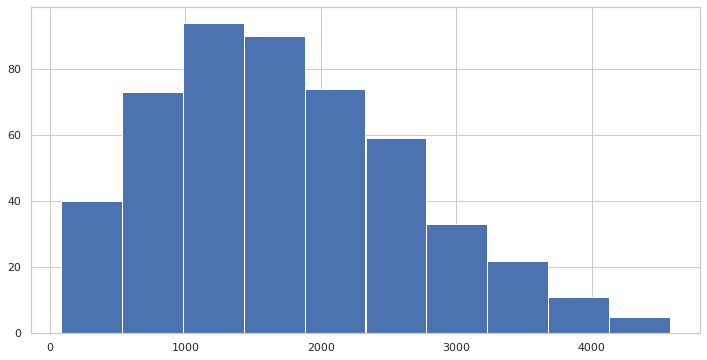

In [92]:
total_bill.query('group == "test"')['orders_price'].hist()

In [93]:
A = total_bill.query('group == "control"').orders_price
B = total_bill.query('group == "test"').orders_price

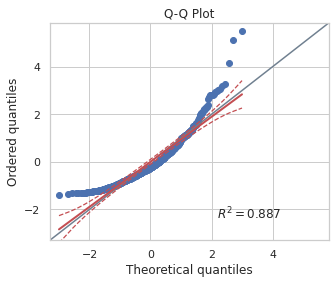

In [94]:
pg.qqplot(A)

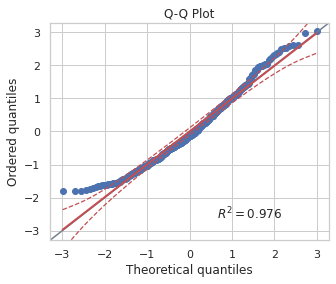

In [95]:
pg.qqplot(B)

In [96]:
pg.normality(data=total_bill, dv="orders_price", group= "group", method="shapiro")

,W,pval,normal
control,0.888535,8.713837e-19,False
test,0.974877,1.408599e-07,False


In [97]:
pg.normality(data=total_bill, dv="orders_price", group= "group", method="normaltest")

,W,pval,normal
control,165.141459,1.380345e-36,False
test,21.243034,2.438562e-05,False


In [98]:
pg.homoscedasticity(data=total_bill, dv="orders_price", group="group")

,W,pval,equal_var
levene,18.466658,0.000019,False


Распределение ни в одной из групп не является нормальным. Дисперсии не равны.

Может, здесь тоже попробовать логарифмирование?

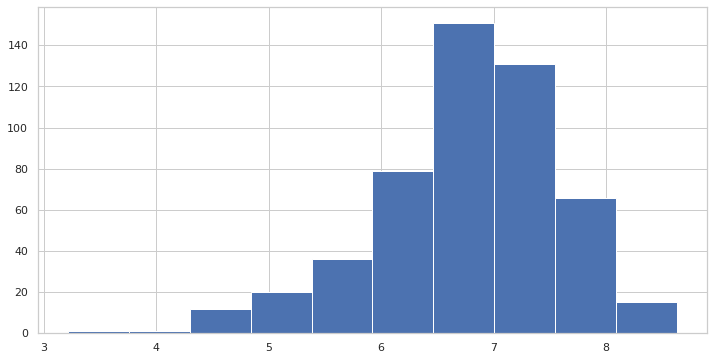

In [99]:
old_group = total_bill.query('group == "control"')
np.log(old_group['orders_price']).hist()

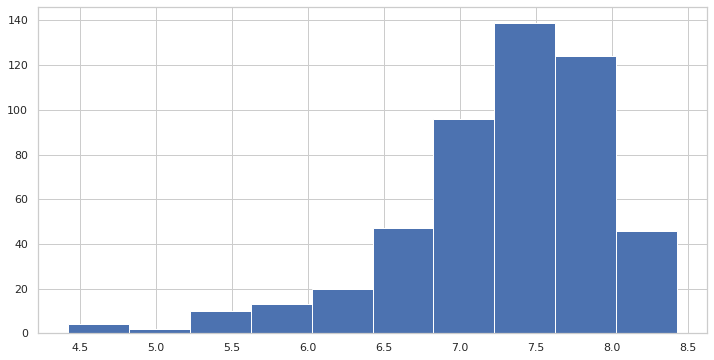

In [100]:
new_group = total_bill.query('group == "test"')
np.log(new_group['orders_price']).hist()

Логарифмирование и здесь не помогло.

Так как здесь тоже достаточно большая выборка, но не соблюдена гомогенность дисперсиии, то можно снова применить t-тест Уэлча.

In [101]:
statistic, pvalue = ss.ttest_ind(total_bill.query('group == "test"')['orders_price'], total_bill.query('group == "control"')['orders_price'], equal_var=False)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 11.208629753614108
p-значение: 1.5721664294812324e-27
Отвергаем нулевую гипотезу. Средние значения выборок различаются


**Вывод:** Cтатистическая значимость в разнице средних подтверждается. Метрика ATB двух групп значимо различается.

## 3. Вывод

Исходя из результатов проведенного исследования среднее количество товаров в заказе (ANPO) и средний чек на покупателя (ARPU) в тестовой и контрольной группах значимо не различаются, т.е. пользователя как покупали примерно одинаковое число товаров на примерно ту же сумму в одном заказе, так и покупают. 

Однако количество заказов в месяц (ANOUM) в тестовой группе значимо увеличилось по сравнению с контрольной, что говорит о том, что пользователи стали чаще оформлять заказы, чем раньше. Значит, новый алгоритм как минимум увеличил количество заказов в месяц и, как следствие, в целом увеличил среднюю сумму всех заказов, совершаемых полкупателем (AТВ). Возможно, несмотря на отсутствие значимых изменений в ANPO и ARPU, покупатели в каких-то заказах стали приобретать более дорогие товары. 

Стоит включить новую систему рекомендаций на всех пользователей.